In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.model_selection import KFold

import xml.etree.ElementTree as Xet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from IPython.display import Image, HTML
from datetime import datetime
from langdetect import detect
import re
import copy

from utilities import get_hot_data, get_comments, remove_short_comments, build_model, print_my_examples

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.5.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7

In [5]:
VAL_FRACTION = 0.25

In [6]:
MIN_COMMENT_LEN = 25

In [7]:
TOP_N = 5

In [8]:
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1"
MODEL_NAME = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"

## GET DATA

In [11]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '331106',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/tQVVSXcmYLvAoI28cp-2Tg__thumb/img/ahKWaUSws5zja4feB4VexkNV3Mc=/fit-in/200x150/filters:strip_icc()/pic5974859.jpg',
  'name': 'The Witcher: Old World',
  'yearpublished': '2022'},
 {'id': '285192',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/oaD1ZQ3yGj6lacLdtqgdnQ__thumb/img/1mCz7HPEFMeqaqJHsDZwEUc9ftw=/fit-in/200x150/filters:strip_icc()/pic5558118.png',
  'name': 'Destinies',
  'yearpublished': '2021'}]

In [12]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

reading dataframe from csv file...


,id,username,rating,value
0,331106,Allethar,N/A,I played twice during testing phase - the vani...
1,331106,arnaud4matagot,9.0,tested online
2,331106,arsaghar,3.0,"The game, apart from really nice figures and g..."
3,331106,Baartoszz,8.0,Played near final prototype. Great combination...
4,331106,Bart1991,N/A,"Backed on Kickstarter, hasn't arrived yet"
...,...,...,...,...
93052,167791,z_zadar,9.0,Some games are so much fun. Others can be a li...
93053,167791,_Czid_,8.0,Have played with Elysium and Prelude expansion...
93054,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
93055,167791,_mun_,10.0,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [13]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  

In [14]:
comments_df["value"] = comments_df["value"].astype(str)

In [15]:
# REMOVE URLs FROM COMMENTS

In [16]:
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]

In [18]:
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 15415 for 'remove_short_comments' - min len: 25 - method: unrated


In [19]:
# REMOVE NON ENGLISH COMMENTS

In [20]:
# !conda install -c conda-forge langdetect

In [21]:
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)

In [22]:
# comments_df = add_comments_lang(comments_df)

In [23]:
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [24]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

10.0       15004
9.0        14397
8.0        12237
7.0         6891
N/A         6516
           ...  
8.988          1
3.75           1
8.99621        1
3.92           1
8.5462         1
Name: rating, Length: 514, dtype: int64

In [25]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(71126, 5)

In [26]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(6516, 5)

## CREATE TRAINING AND VALIDATION DATA

In [27]:
# use rated comments (reviews) to train the model

In [28]:
rated_comments = rated_comments.sample(frac=1)

In [29]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [30]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'After a single play, I love this. Aesthetically pleasing. Easy to learn. Tons of depth. Just overall, really nice. Even the theme feels right (somehow...). Well done, kudos to everyone involved.'

In [31]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'The components are great, but the gameplay is definitely not mine.'

## COMPOSE MODEL

In [32]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

## CLASSIFIER

In [34]:
def build_classifier():
    return build_model(hub_layer=None, pre_trained_model_name=MODEL_NAME, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=512, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
70/70 - 5s - loss: 0.5739 - accuracy: 0.7232 - val_loss: 0.4628 - val_accuracy: 0.8456
Epoch 2/100
70/70 - 3s - loss: 0.4044 - accuracy: 0.8521 - val_loss: 0.3727 - val_accuracy: 0.8564
Epoch 3/100
70/70 - 3s - loss: 0.3228 - accuracy: 0.8748 - val_loss: 0.3319 - val_accuracy: 0.8691
Epoch 4/100
70/70 - 4s - loss: 0.2733 - accuracy: 0.8947 - val_loss: 0.3188 - val_accuracy: 0.8730
Epoch 5/100
70/70 - 3s - loss: 0.2367 - accuracy: 0.9093 - val_loss: 0.3206 - val_accuracy: 0.8733
Epoch 6/100
70/70 - 3s - loss: 0.2073 - accuracy: 0.9228 - val_loss: 0.3289 - val_accuracy: 0.8708
Epoch 7/100
70/70 - 3s - loss: 0.1834 - accuracy: 0.9334 - val_loss: 0.3456 - val_accuracy: 0.8675
Epoch 8/100
70/70 - 3s - loss: 0.1631 - accuracy: 0.9426 - val_loss: 0.3674 - val_accuracy: 0.8639
Epoch 9/100
70/70 - 3s - loss: 0.1463 - accuracy: 0.9492 - val_loss: 0.3928 - val_accuracy: 0.8587
47/47 - 0s - loss: 0.3916 - accuracy: 0.8579
Epoch 1/100
70/70 - 4s - loss: 0.5139 - accuracy: 0.8284 - val_l

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000021690DE2F40>,
             param_grid={})

In [35]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [36]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [38]:
epochs = range(1, len(acc) + 1) 

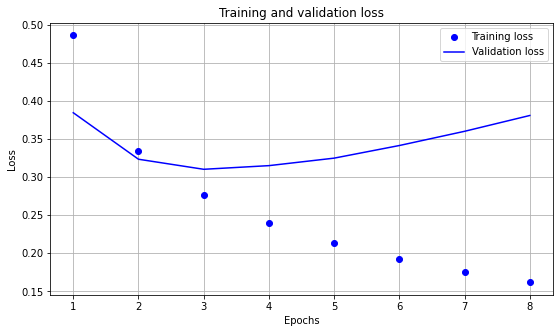

In [39]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

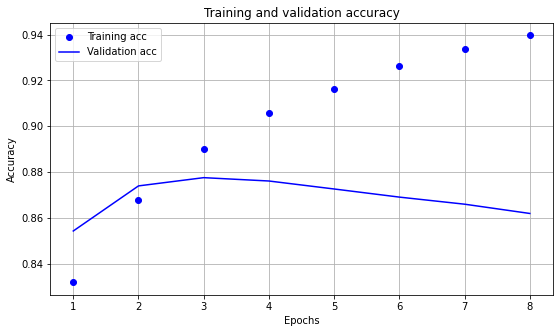

In [40]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [42]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"After a single play, I love this. Aesthetically pleasing. Easy to learn. Tons of depth. Just overall, really nice. Even the theme feels right (somehow...). Well done, kudos to everyone involved."
score: 1.000000
actual value:1

input:
"Only one play in, but great gaming experience! It does take some time depending if you include the extra project cards. The player mats get a bit crowded and can easily be bumped. I highly recommend doing the card draft (in the rules), it can really help you get useful cards. Rulebook a bit disjointed, you have to flip back and forth to find the rule you need. Also don't bother with the beginner corporations, the theme of the different corporation cards will help determine your game strategy ... go for planting forests or microbe research or nuclear bombs.  Edit: Played 2 player without the Corporate Era project cards which, while making the game a little less complex, sped up the game quite a bit. The draft still worked, but it gets less importa

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [43]:
## APPLY MODEL ON NON-RATED COMMENTS

In [44]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

13/13 - 0s
input:
"P: 1-5, T: 90-120 min Work of Art; super high production value, artwork, minis, components (especially with collector's edition). Asymmetrical player mats (a.la Terra Mystica, which draws a fair comparison on paper) Engine building, area control. Low luck elements, player decisions have high impact. -Heavy Euro game, plays longer than advertised. A 4X game that doesn't do all of it all that well; not a fan of the random/bidding combat (nor tactics rewarding piling on the weakest player). Theme is fairly weak apart from the artwork. Despite the individual player powers a criticism suggests a railroaded race of efficiency with replayability concerns. Price/availability concerns?"
score: 1.000000

input:
"Essen 2013. Boîte plastifiée. Protections cartes : MG Euro. Règles VF OK."
score: 1.000000

input:
"Sleeves: Rebel Standard USA Premium (56/87 mm)"
score: 1.000000

input:
"Kickstarter  Voraussichtl. Lieferung August 2017"
score: 1.000000

input:
"The trailer for this 

## REGRESSOR

In [45]:
def build_regressor():
    return build_model(hub_layer, pre_trained_model_name=MODEL_NAME, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000021AAF9B80A0>,
             param_grid={})

In [46]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [47]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [48]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [49]:
epochs = range(1, len(mean_squared_error) + 1) 

In [50]:
print(f"MEAN SQUARED ERROR (VALIDATION SET): {val_mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (VALIDATION SET): 2.59


In [51]:
print(f"MEAN SQUARED ERROR (TRAINING SET): {mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (TRAINING SET): 1.02


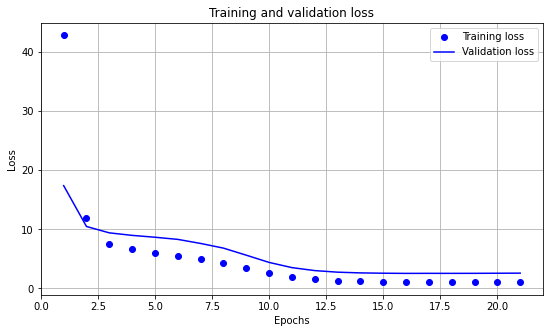

In [52]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

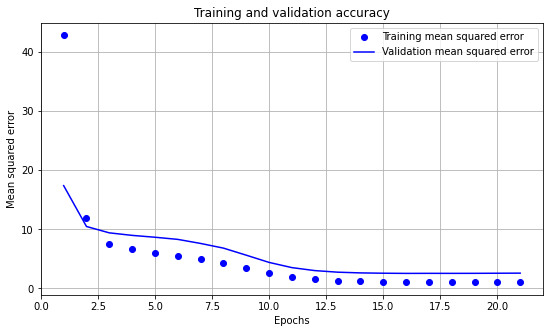

In [53]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [54]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"After a single play, I love this. Aesthetically pleasing. Easy to learn. Tons of depth. Just overall, really nice. Even the theme feels right (somehow...). Well done, kudos to everyone involved."
score: 9.02
actual: 9.20 

input: 
"Only one play in, but great gaming experience! It does take some time depending if you include the extra project cards. The player mats get a bit crowded and can easily be bumped. I highly recommend doing the card draft (in the rules), it can really help you get useful cards. Rulebook a bit disjointed, you have to flip back and forth to find the rule you need. Also don't bother with the beginner corporations, the theme of the different corporation cards will help determine your game strategy ... go for planting forests or microbe research or nuclear bombs.  Edit: Played 2 player without the Corporate Era project cards which, while making the game a little less complex, sped up the game quite a bit. The draft still worked, but it gets less important 

## COMPARE CLASSIFIER VS REGRESSOR

In [55]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

"1 year waiting... I hope it will be worth it! :)"
    reg score: 9.31
    clf score: 1

"Seems to be a good game, looks good, components are good and so on. There is an idea in the game and I'm looking forward for more plays. The game needs fast players to stay enjoyable, I think.  The players are families on the Mediterranean area, building cities, producing goods, trading them and so on. In the end everything is converted to the points."
    reg score: 8.02
    clf score: 1

"Played this 3 times in Summer 2019. A bit "dark"/nightmare-inducing but only minimally. Fun story. Not a ton of replayability in my opinion but Eric may disagree. Research told me it was more highly rated than the original Arkham Horror/less setup, and that seems to be true."
    reg score: 7.14
    clf score: 1

"Crazy popular, but I'm not convinced by the theme, apparently has AWESOME automa for solo play"
    reg score: 7.80
    clf score: 1

"Folded Space Insert Mayday Green P Sleeves"
    reg score: 8.51
 

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [56]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|        id |   rating_mean |   rating_count |
|-----------|---------------|----------------|
|  54998.00 |          7.55 |        2687.00 |
| 124361.00 |          8.19 |        3847.00 |
| 128671.00 |          7.57 |        1073.00 |
| 162886.00 |          8.36 |        3522.00 |
| 167355.00 |          8.42 |        1812.00 |


In [57]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [58]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments['rating'] = not_rated_comments['rating'].clip(0, 10)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|        id |   rating_mean |   rating_count |
|-----------|---------------|----------------|
|  54998.00 |          7.63 |         197.00 |
| 124361.00 |          8.04 |         256.00 |
| 128671.00 |          7.66 |          97.00 |
| 162886.00 |          8.16 |         314.00 |
| 167355.00 |          8.13 |         215.00 |


In [59]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [60]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/tQVVSXc...","<a href=""https://boardgamegeek.com/boardgame/3...",7.078947,8.326513,7.702730,1,2022
1,"<img src=""https://cf.geekdo-images.com/oaD1ZQ3...","<a href=""https://boardgamegeek.com/boardgame/2...",8.310714,7.201284,8.024173,2,2021
2,"<img src=""https://cf.geekdo-images.com/6GqH14T...","<a href=""https://boardgamegeek.com/boardgame/3...",7.840447,7.773983,7.834563,3,2020
3,"<img src=""https://cf.geekdo-images.com/KTKXgGG...","<a href=""https://boardgamegeek.com/boardgame/3...",10.000000,6.279705,8.139853,4,2021
4,"<img src=""https://cf.geekdo-images.com/gTxav_K...","<a href=""https://boardgamegeek.com/boardgame/2...",7.841832,7.758829,7.812926,5,2021


In [61]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [62]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,The Witcher: Old World,7.078947,8.326513,7.702730,1,2022
2,,Destinies,8.310714,7.201284,8.024173,2,2021
3,,Lost Ruins of Arnak,7.840447,7.773983,7.834563,3,2020
4,,The Goonies: Never Say Die,10.000000,6.279705,8.139853,4,2021
5,,Oath: Chronicles of Empire and Exile,7.841832,7.758829,7.812926,5,2021


In [63]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,The Goonies: Never Say Die,10.000000,6.279705,8.139853,4,2021
2,,Lost Ruins of Arnak: The Search for Professor Kutil,9.100000,8.592831,9.015472,6,2021
3,,Eclipse: Second Dawn for the Galaxy,8.737235,8.392140,8.683640,49,2020
4,,Brass: Birmingham,8.682181,8.027668,8.622820,24,2018
5,,Middara: Unintentional Malum – Act 1,8.636377,8.130491,8.516650,28,2019


In [64]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Lost Ruins of Arnak: The Search for Professor Kutil,9.100000,8.592831,9.015472,6,2021
2,,Eclipse: Second Dawn for the Galaxy,8.737235,8.392140,8.683640,49,2020
3,,Brass: Birmingham,8.682181,8.027668,8.622820,24,2018
4,,Gloomhaven: Jaws of the Lion,8.600844,8.014546,8.543423,22,2020
5,,Middara: Unintentional Malum – Act 1,8.636377,8.130491,8.516650,28,2019


In [65]:
# model.save('saved_model\my_model')

In [66]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [67]:
# some examples on "long" comments vs short comments

In [68]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [69]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\"\nscore: {c['rating']:.2f}\n"), axis=1);

"Seems to just be facts about birds and not any kind of simulation of the lives of birds. Like, this bird weighs X kilos, and not what how birds interact with their ecosystem. More stamp collecting than physics."
score: 4.57

"Managed to acquire 2 base boxes and dunwich for cheap and in new condition. Just need to play it all together now."
score: 5.67

"Bought it on sale but haven't had the confidence to start playing yet because I'm still overwhelmed by the sheer volume."
score: 5.86

"People keep telling me I need to play this game, so I watched a play-through and yeah, it looks like fun."
score: 6.34

"Includes $50 coins  Encounter and Factory cards: Fantasy Flight Games Tarot Card Sleeves with the excess length trimmed off of them  From Meeple Source:  Scythe, tokens (19)  Scythe, Lg action tokens (7)  Scythe stickers "
score: 6.45

"Italian translation of the game is a big fact for italian potential buyers, since not all friends we play with talk or can read English."
score: 6.87